# Model Selection, Underfitting, and Overfitting

Explore these concepts interactively
by fitting polynomials to data

In [1]:
import math
import numpy as np
import torch
from torch import nn
from d2l import torch as d2l

Use the following cubic polynomial to generate the labels
$$y = 5 + 1.2x - 3.4\frac{x^2}{2!} + 5.6 \frac{x^3}{3!} + \epsilon \text{ where }
\epsilon \sim \mathcal{N}(0, 0.1^2)$$

In [2]:
max_degree = 20
n_train, n_test = 100, 100
true_w = np.zeros(max_degree)
true_w[0:4] = np.array([5, 1.2, -3.4, 5.6])

features = np.random.normal(size=(n_train + n_test, 1))
np.random.shuffle(features)
poly_features = np.power(features, np.arange(max_degree).reshape(1, -1))
for i in range(max_degree):
    poly_features[:, i] /= math.gamma(i + 1)
labels = np.dot(poly_features, true_w)
labels += np.random.normal(scale=0.1, size=labels.shape)

Take a look at the first 2 samples

In [4]:
true_w, features, poly_features, labels = [
    torch.tensor(x, dtype=torch.float32)
    for x in [true_w, features, poly_features, labels]]

features[:2], poly_features[:2, :], labels[:2]

(tensor([[-0.2569],
         [ 0.3296]]),
 tensor([[ 1.0000e+00, -2.5685e-01,  3.2986e-02, -2.8242e-03,  1.8135e-04,
          -9.3160e-06,  3.9880e-07, -1.4633e-08,  4.6982e-10, -1.3408e-11,
           3.4439e-13, -8.0416e-15,  1.7213e-16, -3.4008e-18,  6.2393e-20,
          -1.0684e-21,  1.7151e-23, -2.5913e-25,  3.6977e-27, -4.9987e-29],
         [ 1.0000e+00,  3.2964e-01,  5.4333e-02,  5.9701e-03,  4.9201e-04,
           3.2437e-05,  1.7821e-06,  8.3924e-08,  3.4581e-09,  1.2666e-10,
           4.1753e-12,  1.2512e-13,  3.4372e-15,  8.7158e-17,  2.0522e-18,
           4.5100e-20,  9.2919e-22,  1.8018e-23,  3.2997e-25,  5.7249e-27]]),
 tensor([4.6422, 5.4296]))

Implement a function to evaluate the loss on a given dataset

In [5]:
def evaluate_loss(net, data_iter, loss):  
    """Evaluate the loss of a model on the given dataset."""
    metric = d2l.Accumulator(2)
    for X, y in data_iter:
        out = net(X)
        y = y.reshape(out.shape)
        l = loss(out, y)
        metric.add(l.sum(), l.numel())
    return metric[0] / metric[1]

Define the training function

In [6]:
def train(train_features, test_features, train_labels, test_labels,
          num_epochs=400):
    loss = nn.MSELoss()
    input_shape = train_features.shape[-1]
    net = nn.Sequential(nn.Linear(input_shape, 1, bias=False))
    batch_size = min(10, train_labels.shape[0])
    train_iter = d2l.load_array((train_features, train_labels.reshape(-1, 1)),
                                batch_size)
    test_iter = d2l.load_array((test_features, test_labels.reshape(-1, 1)),
                               batch_size, is_train=False)
    trainer = torch.optim.SGD(net.parameters(), lr=0.01)
    animator = d2l.Animator(xlabel='epoch', ylabel='loss', yscale='log',
                            xlim=[1, num_epochs], ylim=[1e-3, 1e2],
                            legend=['train', 'test'])
    for epoch in range(num_epochs):
        d2l.train_epoch_ch3(net, train_iter, loss, trainer)
        if epoch == 0 or (epoch + 1) % 20 == 0:
            animator.add(epoch + 1, (evaluate_loss(
                net, train_iter, loss), evaluate_loss(net, test_iter, loss)))
    print('weight:', net[0].weight.data.numpy())

Third-Order Polynomial Function Fitting (Normal)

weight: [[ 4.9936824  1.2302015 -3.402595   5.5847616]]


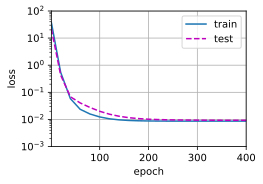

In [7]:
train(poly_features[:n_train, :4], poly_features[n_train:, :4],
      labels[:n_train], labels[n_train:])

Linear Function Fitting (Underfitting)

weight: [[2.5493171 5.3364143]]


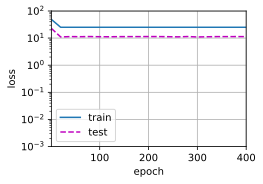

In [8]:
train(poly_features[:n_train, :2], poly_features[n_train:, :2],
      labels[:n_train], labels[n_train:])

Higher-Order Polynomial Function Fitting  (Overfitting)

weight: [[ 4.98487806e+00  1.27825654e+00 -3.35424185e+00  5.38255644e+00
  -2.65596479e-01  4.29526359e-01  5.86663604e-01 -3.34661543e-01
  -4.17502820e-02 -2.33802021e-01  2.09837109e-01 -1.16521575e-01
  -1.49637341e-01 -1.93751618e-01  2.20980927e-01  3.49802002e-02
  -1.06689326e-01 -2.08369980e-04 -1.53889835e-01 -1.28053337e-01]]


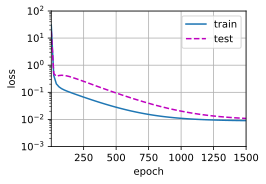

In [9]:
train(poly_features[:n_train, :], poly_features[n_train:, :],
      labels[:n_train], labels[n_train:], num_epochs=1500)